In [304]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from catboost import CatBoostRegressor

from sklearn.inspection import permutation_importance

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings('ignore')

In [305]:
with open('/opt/ml/data/20230420_081152_catboost_data.pt',"rb") as f:
    data = pickle.load(f)

In [306]:
sota = pd.read_csv('/opt/ml/code/submit/final_sota.csv')
sota['isbn'] = sota['isbn'].map(data['isbn2idx'])

In [307]:
X_train, X_valid, y_train, y_valid = train_test_split(
                                                    data['train'].drop(['rating'], axis=1),
                                                    data['train']['rating'],
                                                    test_size=0.1,
                                                    random_state=42,
                                                    shuffle=True
                                                    )
data['X_train'], data['X_valid'], data['y_train'], data['y_valid'] = X_train, X_valid, y_train, y_valid

In [308]:
reduced_columns = ['user_id', 'isbn', 'age', 'location_city', 'location_state',
       'location_country', 'category', 'category_high', 'publisher',
       'language', 'book_author', 'year_of_publication', 'age_map',
       'year_of_publication_map', 'user_rating_var' 'age_map_5']

In [309]:
unique_values = pd.DataFrame({'isbn':data['train']['isbn'].value_counts().index, 'count':data['train']['isbn'].value_counts().values})
len(unique_values[unique_values['count'] >= 2])/len(unique_values) * 100

31.88931782981576

In [310]:
popular_books = unique_values[unique_values['count'] >= 2]['isbn'].values

In [311]:
test_isbn = sota['isbn'].unique()
train_isbn_rating = data['train'][data['train']['isbn'].isin(test_isbn)].groupby('isbn')['rating'].mean()

In [312]:
predict_isbn_rating = sota.groupby('isbn')['rating'].mean()

In [313]:
pred_popular_books = predict_isbn_rating[predict_isbn_rating.index.isin(popular_books)]

In [314]:
train_popular_books = train_isbn_rating[train_isbn_rating.index.isin(popular_books)]

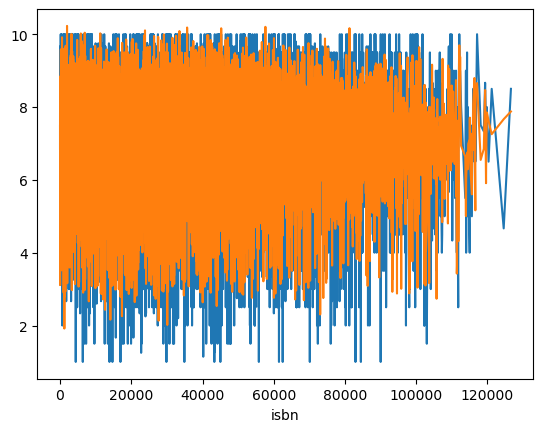

In [315]:
train_popular_books.plot()
pred_popular_books.plot()
plt.show()

In [316]:
train_popular_books.name = 'rating_train_mean'

In [317]:
sota_mean = sota.merge(train_popular_books, on='isbn', how='left').dropna()

In [318]:
idx = sota.merge(train_popular_books, on='isbn', how='left').dropna().index
sota.loc[idx, 'rating_mean'] = (sota.loc[idx, 'rating'] + sota_mean.loc[idx, 'rating_train_mean'])/2

In [319]:
sota['rating_mean'] = sota['rating_mean'].fillna(sota['rating'])

In [320]:
NCF = pd.read_csv('/opt/ml/code/submit/sw-0.9-0.1-sw-0.9-0.1-sota-multiple_model-20230412_042710_NCF_y_edit.csv')

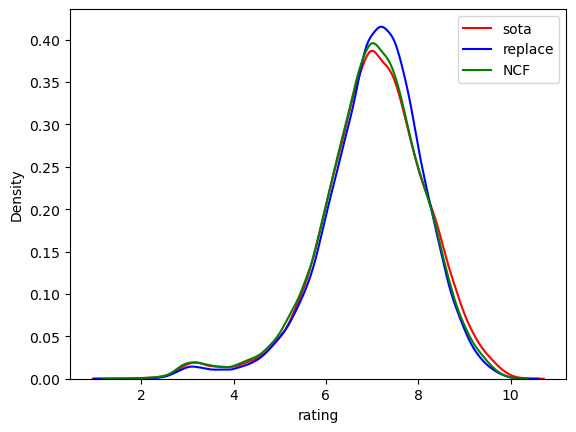

In [321]:
sns.kdeplot(sota['rating'], color='r')
sns.kdeplot(sota['rating_mean'], color='b')
sns.kdeplot(NCF['rating'], color='g')
plt.legend(['sota', 'replace', 'NCF'])
plt.show()

In [322]:
sota

,user_id,isbn,rating,rating_mean
0,11676,0,7.160237,7.008690
1,116866,0,7.808428,7.332785
2,152827,1,7.334165,7.334165
3,157969,2,7.750526,7.675263
4,67958,3,7.746620,7.659024
...,...,...,...,...
76694,278543,149565,6.309984,6.309984
76695,278563,149566,6.069714,6.069714
76696,278633,149567,6.190516,6.190516
76697,278668,149568,4.961177,4.961177


In [325]:
sota = sota.drop(columns='rating')
sota = sota.rename(columns={'rating_mean':'rating'})

In [329]:
sota.to_csv('final_sub.csv', index=False)

In [323]:
sota['rating']

0        7.160237
1        7.808428
2        7.334165
3        7.750526
4        7.746620
           ...   
76694    6.309984
76695    6.069714
76696    6.190516
76697    4.961177
76698    5.545987
Name: rating, Length: 76699, dtype: float64

In [324]:
X_train

,user_id,isbn,age,location_city,location_state,location_country,category,publisher,book_author,year_of_publication,user_rating_var
98098,28791,10417,39.0,545,93,11,0,81,5487,2002.0,6.966667
274380,31440,99309,34.0,1812,47,2,0,181,1440,1989.0,8.000000
107274,9220,12224,38.0,664,47,2,4,5,275,2001.0,1.000000
185971,9821,39066,41.0,2001,18,2,0,437,17275,1988.0,3.388808
31307,15473,1635,35.0,695,41,2,4,368,275,2001.0,6.000000
...,...,...,...,...,...,...,...,...,...,...,...
119879,2752,14936,32.0,1531,216,2,4,22,1326,1998.0,3.073417
259178,8108,86566,39.0,1874,21,2,0,7068,35785,1995.0,3.000000
131932,10534,18168,50.0,3684,41,2,0,22,679,1999.0,2.410714
146867,40246,22419,24.0,8432,852,12,4,42,162,1976.0,1.000000


<Axes: xlabel='rating', ylabel='Density'>

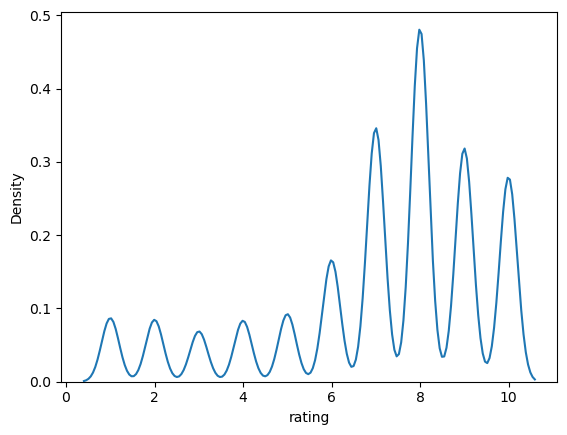

In [163]:
sns.kdeplot(y_train)